# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression



In [1]:
version  = '07'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedice"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedice.values
    n_s  = xr.open_dataset(fname).n_rimedice.values
    r_s  = xr.open_dataset(fname).rime_rimedice.values
    v_s  = xr.open_dataset(fname).rvol_rimedice.values
    cwc  = xr.open_dataset(fname).cwc.values
    r_c  = xr.open_dataset(fname).rc.values
    # process rates
    mult_num = xr.open_dataset(fname).mult_rimedice_num.values
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    cwc = np.log(cwc, where=cwc>q_min, out=np.nan*n_s)
    r_c = np.log(r_c, where=r_c>q_min, out=np.nan*n_s)
    mult_num = np.log(mult_num, where=mult_num>p_min, out=np.nan*mult_num)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, cwc, r_c, temp, rho, mult_num ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'cwc', 'r_c', 'temp', 'rho', 'mult_num' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s           n_s           r_s           v_s           cwc  \
count  14078.000000  14078.000000  14078.000000  14078.000000  14078.000000   
mean     -12.698940      6.673739    -13.951161    -19.211088     -9.156704   
std        2.271039      2.229773      2.439402      2.433998      1.725415   
min      -22.997749     -5.568107    -24.489544    -29.506315    -25.809702   
25%      -13.744028      5.794430    -15.414664    -20.665257    -10.337352   
50%      -12.583460      6.907555    -13.987112    -19.257606     -9.142682   
75%      -11.262147      8.030841    -12.286865    -17.569462     -7.980700   
max       -6.634147     14.461409     -6.910348    -12.073606     -4.456750   

                r_c          temp           rho      mult_num  
count  14078.000000  14078.000000  14078.000000  14078.000000  
mean     -11.280735    267.533234      1.040022     -4.947166  
std        0.448955      1.427410      0.053048      3.861361  
min      -12.203955    264.929993      0.847000    -16.801191  
25%      -11.588814    266.329987      1.004000     -7.584574  
50%      -11.260433    267.500000      1.040000     -4.791825  
75%      -10.966997    268.730011      1.077000     -2.111419  
max      -10.271247    270.149994      1.213000      5.784613

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s       cwc        r_c        temp  \
0 -11.834965  7.581669 -16.452967 -21.468021 -8.772085 -12.155304  265.890015   
1 -11.692698  7.744050 -15.343876 -20.366152 -8.859683 -12.155304  265.950012   
4 -11.591861  7.757564 -14.299613 -19.343794 -9.142682 -12.155304  266.140015   
5 -11.564956  7.753838 -14.119457 -19.170822 -9.247005 -12.155304  266.209991   
6 -11.541376  7.747640 -13.978606 -19.037312 -9.354211 -12.155304  266.279999   

     rho  mult_num  
0  1.038 -1.053228  
1  1.039 -0.997249  
4  1.042 -0.982484  
5  1.043 -0.990061  
6  1.044 -1.020494

In [11]:
dataset_train.describe()

q_s          n_s          r_s          v_s          cwc  \
count  9918.000000  9918.000000  9918.000000  9918.000000  9918.000000   
mean    -12.677525     6.692483   -13.932940   -19.194176    -9.148585   
std       2.253384     2.221966     2.424554     2.420783     1.731141   
min     -22.986727    -5.568107   -24.489544   -29.506315   -25.809702   
25%     -13.733079     5.809748   -15.398087   -20.652318   -10.340444   
50%     -12.554609     6.929859   -13.956354   -19.230856    -9.138031   
75%     -11.256232     8.047781   -12.277311   -17.557359    -7.966186   
max      -6.634147    14.461409    -6.910348   -12.073606    -4.456750   

               r_c         temp          rho     mult_num  
count  9918.000000  9918.000000  9918.000000  9918.000000  
mean    -11.276855   267.532349     1.039971    -4.944442  
std       0.448971     1.431122     0.053194     3.876237  
min     -12.203955   264.929993     0.847000   -16.801191  
25%     -11.561171   266.309998     1.004000    -7.581596  
50%     -11.256015   267.510010     1.039000    -4.780978  
75%     -10.961025   268.730011     1.077000    -2.099681  
max     -10.271247   270.149994     1.213000     5.784613

In [12]:
dataset_test.describe()

q_s          n_s          r_s          v_s          cwc  \
count  2094.000000  2094.000000  2094.000000  2094.000000  2094.000000   
mean    -12.720925     6.638037   -13.959901   -19.217598    -9.165838   
std       2.293875     2.239457     2.447961     2.444632     1.706908   
min     -22.399591    -4.597401   -22.614603   -27.863445   -21.881628   
25%     -13.719450     5.841064   -15.404154   -20.644871   -10.319003   
50%     -12.588989     6.883463   -14.017719   -19.287697    -9.105980   
75%     -11.277774     7.970542   -12.310151   -17.579751    -7.998399   
max      -6.973351    13.757415    -7.318253   -12.484861    -4.565949   

               r_c         temp          rho     mult_num  
count  2094.000000  2094.000000  2094.000000  2094.000000  
mean    -11.293517   267.519287     1.040287    -4.897125  
std       0.446799     1.417134     0.052617     3.816265  
min     -12.203955   265.010010     0.852000   -16.660421  
25%     -11.595579   266.332489     1.003250    -7.522460  
50%     -11.283553   267.480011     1.042000    -4.777577  
75%     -10.987736   268.670013     1.077000    -2.024493  
max     -10.271247   270.140015     1.199000     5.372186

In [13]:
dataset_val.describe()

q_s          n_s          r_s          v_s          cwc  \
count  2066.000000  2066.000000  2066.000000  2066.000000  2066.000000   
mean    -12.779470     6.619949   -14.029774   -19.285675    -9.186417   
std       2.330534     2.256964     2.500607     2.485687     1.716974   
min     -22.997749    -5.513096   -23.319981   -28.545238   -21.733868   
25%     -13.828204     5.665929   -15.505237   -20.748833   -10.343544   
50%     -12.725704     6.818547   -14.074247   -19.362276    -9.190537   
75%     -11.277854     7.952193   -12.333580   -17.603923    -8.020977   
max      -6.664652    14.455468    -7.602844   -12.894670    -4.878292   

               r_c         temp          rho     mult_num  
count  2066.000000  2066.000000  2066.000000  2066.000000  
mean    -11.286407   267.551727     1.039998    -5.010958  
std       0.450971     1.420421     0.052808     3.836151  
min     -12.203955   265.010010     0.863000   -16.801191  
25%     -11.613409   266.380005     1.003000    -7.644241  
50%     -11.260433   267.459991     1.041000    -4.843899  
75%     -10.979143   268.739990     1.076000    -2.228547  
max     -10.276542   270.140015     1.205000     5.510457

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s          n_s          r_s          v_s          cwc  \
count  9819.000000  9819.000000  9819.000000  9819.000000  9819.000000   
mean    -12.591374     6.782780   -13.856764   -19.117128    -9.148257   
std       2.092516     2.037591     2.312706     2.305802     1.731157   
min     -19.971708    -2.363387   -22.608919   -27.623251   -25.809702   
25%     -13.695818     5.853481   -15.360285   -20.603086   -10.334270   
50%     -12.531969     6.951485   -13.927962   -19.202833    -9.133379   
75%     -11.239355     8.059087   -12.254476   -17.532913    -7.966186   
max      -6.634147    14.461409    -6.910348   -12.073606    -4.456750   

               r_c         temp          rho     mult_num  
count  9819.000000  9819.000000  9819.000000  9819.000000  
mean    -11.276854   267.526855     1.039866    -4.863671  
std       0.449663     1.431753     0.053294     3.801702  
min     -12.203955   264.929993     0.847000   -16.801191  
25%     -11.563577   266.309998     1.004000    -7.497925  
50%     -11.256015   267.500000     1.039000    -4.739416  
75%     -10.961025   268.730011     1.077000    -2.072818  
max     -10.271247   270.149994     1.213000     5.784613

In [17]:
dataset_test.describe()

q_s          n_s          r_s          v_s          cwc  \
count  2068.000000  2068.000000  2068.000000  2068.000000  2068.000000   
mean    -12.614921     6.747899   -13.866400   -19.123316    -9.159116   
std       2.101571     2.019879     2.314429     2.308382     1.705994   
min     -19.932991    -1.712301   -21.180946   -26.320421   -21.881628   
25%     -13.674945     5.923211   -15.347711   -20.592896   -10.299501   
50%     -12.563820     6.899284   -13.994590   -19.256721    -9.097012   
75%     -11.241678     8.002351   -12.275439   -17.563511    -7.997656   
max      -6.973351    13.757415    -7.318253   -12.484861    -4.565949   

               r_c         temp          rho     mult_num  
count  2068.000000  2068.000000  2068.000000  2068.000000  
mean    -11.292566   267.509949     1.040182    -4.789028  
std       0.448616     1.418069     0.052778     3.702386  
min     -12.203955   265.010010     0.852000   -16.395727  
25%     -11.599344   266.329987     1.003000    -7.356733  
50%     -11.283243   267.450012     1.042000    -4.720435  
75%     -10.984317   268.670013     1.077000    -1.991681  
max     -10.271247   270.140015     1.199000     5.372186

### Pairplot

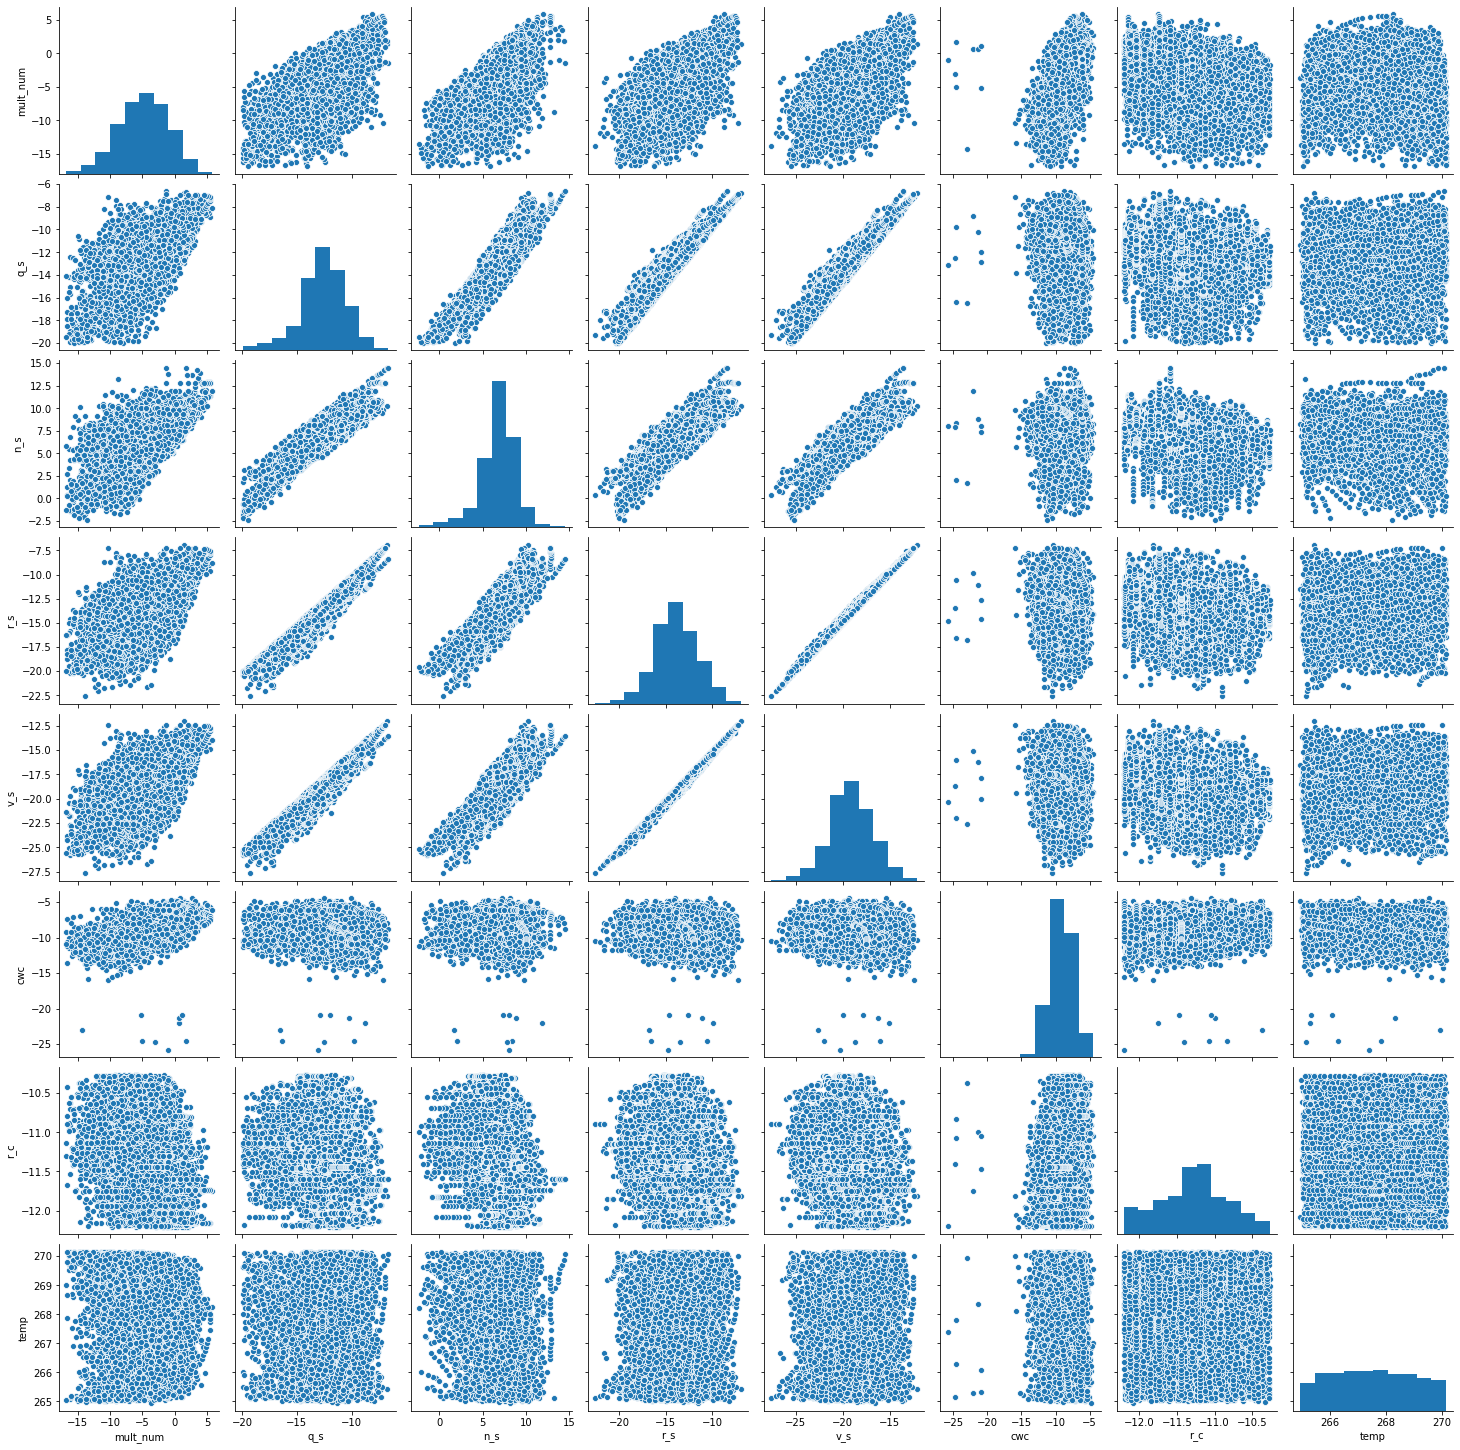

In [18]:
sns.pairplot(dataset_train[["mult_num","q_s","n_s","r_s","v_s","cwc","r_c","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("mult_num")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean       std         min         25%         50%  \
q_s   9819.0  -12.591374  2.092516  -19.971708  -13.695818  -12.531969   
n_s   9819.0    6.782780  2.037591   -2.363387    5.853481    6.951485   
r_s   9819.0  -13.856764  2.312706  -22.608919  -15.360285  -13.927962   
v_s   9819.0  -19.117128  2.305802  -27.623251  -20.603086  -19.202833   
cwc   9819.0   -9.148257  1.731157  -25.809702  -10.334270   -9.133379   
r_c   9819.0  -11.276854  0.449663  -12.203955  -11.563577  -11.256015   
temp  9819.0  267.526855  1.431753  264.929993  266.309998  267.500000   

             75%         max  
q_s   -11.239355   -6.634147  
n_s     8.059087   14.461409  
r_s   -12.254476   -6.910348  
v_s   -17.532913  -12.073606  
cwc    -7.966186   -4.456750  
r_c   -10.961025  -10.271247  
temp  268.730011  270.149994

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("mult_num")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s   9819.0  -12.591374  2.092516  -19.971708  -13.695818  -12.531969   
n_s   9819.0    6.782780  2.037591   -2.363387    5.853481    6.951485   
r_s   9819.0  -13.856764  2.312706  -22.608919  -15.360285  -13.927962   
v_s   9819.0  -19.117128  2.305802  -27.623251  -20.603086  -19.202833   
cwc   9819.0   -9.148257  1.731157  -25.809702  -10.334270   -9.133379   
r_c   9819.0  -11.276854  0.449663  -12.203955  -11.563577  -11.256015   
temp  9819.0  267.526855  1.431753  264.929993  266.309998  267.500000   

             75%         max  
q_s   -11.239355   -6.634147  
n_s     8.059087   14.461409  
r_s   -12.254476   -6.910348  
v_s   -17.532913  -12.073606  
cwc    -7.966186   -4.456750  
r_c   -10.961025  -10.271247  
temp  268.730011  270.149994

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("mult_num")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   9819.0  -12.591374  2.092516  -19.971708  -13.695818  -12.531969   
n_s   9819.0    6.782780  2.037591   -2.363387    5.853481    6.951485   
r_s   9819.0  -13.856764  2.312706  -22.608919  -15.360285  -13.927962   
v_s   9819.0  -19.117128  2.305802  -27.623251  -20.603086  -19.202833   
cwc   9819.0   -9.148257  1.731157  -25.809702  -10.334270   -9.133379   
r_c   9819.0  -11.276854  0.449663  -12.203955  -11.563577  -11.256015   
temp  9819.0  267.526855  1.431753  264.929993  266.309998  267.500000   
rho   9819.0    1.039866  0.053294    0.847000    1.004000    1.039000   

             75%         max  
q_s   -11.239355   -6.634147  
n_s     8.059087   14.461409  
r_s   -12.254476   -6.910348  
v_s   -17.532913  -12.073606  
cwc    -7.966186   -4.456750  
r_c   -10.961025  -10.271247  
temp  268.730011  270.149994  
rho     1.077000    1.213000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['mult_num']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

mult_num
count  9819.000000
mean     -4.863671
std       3.801702
min     -16.801191
25%      -7.497925
50%      -4.739416
75%      -2.072818
max       5.784613

In [32]:
train_dataset1.describe()

q_s          n_s          r_s          v_s          cwc  \
count  9819.000000  9819.000000  9819.000000  9819.000000  9819.000000   
mean    -12.591374     6.782780   -13.856764   -19.117128    -9.148257   
std       2.092516     2.037591     2.312706     2.305802     1.731157   
min     -19.971708    -2.363387   -22.608919   -27.623251   -25.809702   
25%     -13.695818     5.853481   -15.360285   -20.603086   -10.334270   
50%     -12.531969     6.951485   -13.927962   -19.202833    -9.133379   
75%     -11.239355     8.059087   -12.254476   -17.532913    -7.966186   
max      -6.634147    14.461409    -6.910348   -12.073606    -4.456750   

               r_c         temp  
count  9819.000000  9819.000000  
mean    -11.276854   267.526855  
std       0.449663     1.431753  
min     -12.203955   264.929993  
25%     -11.563577   266.309998  
50%     -11.256015   267.500000  
75%     -10.961025   268.730011  
max     -10.271247   270.149994

In [33]:
train_dataset2.describe()

q_s          n_s          r_s          v_s          cwc  \
count  9819.000000  9819.000000  9819.000000  9819.000000  9819.000000   
mean    -12.591374     6.782780   -13.856764   -19.117128    -9.148257   
std       2.092516     2.037591     2.312706     2.305802     1.731157   
min     -19.971708    -2.363387   -22.608919   -27.623251   -25.809702   
25%     -13.695818     5.853481   -15.360285   -20.603086   -10.334270   
50%     -12.531969     6.951485   -13.927962   -19.202833    -9.133379   
75%     -11.239355     8.059087   -12.254476   -17.532913    -7.966186   
max      -6.634147    14.461409    -6.910348   -12.073606    -4.456750   

               r_c         temp  
count  9819.000000  9819.000000  
mean    -11.276854   267.526855  
std       0.449663     1.431753  
min     -12.203955   264.929993  
25%     -11.563577   266.309998  
50%     -11.256015   267.500000  
75%     -10.961025   268.730011  
max     -10.271247   270.149994

In [34]:
train_dataset3.describe()

q_s          n_s          r_s          v_s          cwc  \
count  9819.000000  9819.000000  9819.000000  9819.000000  9819.000000   
mean    -12.591374     6.782780   -13.856764   -19.117128    -9.148257   
std       2.092516     2.037591     2.312706     2.305802     1.731157   
min     -19.971708    -2.363387   -22.608919   -27.623251   -25.809702   
25%     -13.695818     5.853481   -15.360285   -20.603086   -10.334270   
50%     -12.531969     6.951485   -13.927962   -19.202833    -9.133379   
75%     -11.239355     8.059087   -12.254476   -17.532913    -7.966186   
max      -6.634147    14.461409    -6.910348   -12.073606    -4.456750   

               r_c         temp          rho  
count  9819.000000  9819.000000  9819.000000  
mean    -11.276854   267.526855     1.039866  
std       0.449663     1.431753     0.053294  
min     -12.203955   264.929993     0.847000  
25%     -11.563577   266.309998     1.004000  
50%     -11.256015   267.500000     1.039000  
75%     -10.961025   268.730011     1.077000  
max     -10.271247   270.149994     1.213000

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s   9819.0  9.707823e-08  1.0 -3.527014 -0.527807  0.028389  0.646121   
n_s   9819.0 -1.149735e-07  1.0 -4.488715 -0.456077  0.082796  0.626380   
r_s   9819.0 -2.257099e-07  1.0 -3.784379 -0.650114 -0.030786  0.692820   
v_s   9819.0  8.861662e-07  1.0 -3.689008 -0.644443 -0.037169  0.687056   
cwc   9819.0  3.492775e-07  1.0 -9.624457 -0.685099  0.008594  0.682822   
r_c   9819.0 -2.331890e-06  1.0 -2.061767 -0.637639  0.046343  0.702366   
temp  9819.0 -2.170774e-07  1.0 -1.813764 -0.849908 -0.018757  0.840337   

           max  
q_s   2.846921  
n_s   3.768483  
r_s   3.003588  
v_s   3.054695  
cwc   2.710042  
r_c   2.236354  
temp  1.832116

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s   9819.0  9.707823e-08  1.0 -3.527014 -0.527807  0.028389  0.646121   
n_s   9819.0 -1.149735e-07  1.0 -4.488715 -0.456077  0.082796  0.626380   
r_s   9819.0 -2.257099e-07  1.0 -3.784379 -0.650114 -0.030786  0.692820   
v_s   9819.0  8.861662e-07  1.0 -3.689008 -0.644443 -0.037169  0.687056   
cwc   9819.0  3.492775e-07  1.0 -9.624457 -0.685099  0.008594  0.682822   
r_c   9819.0 -2.331890e-06  1.0 -2.061767 -0.637639  0.046343  0.702366   
temp  9819.0 -2.170774e-07  1.0 -1.813764 -0.849908 -0.018757  0.840337   

           max  
q_s   2.846921  
n_s   3.768483  
r_s   3.003588  
v_s   3.054695  
cwc   2.710042  
r_c   2.236354  
temp  1.832116

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   9819.0  9.707823e-08  1.0 -3.527014 -0.527807  0.028389  0.646121   
n_s   9819.0 -1.149735e-07  1.0 -4.488715 -0.456077  0.082796  0.626380   
r_s   9819.0 -2.257099e-07  1.0 -3.784379 -0.650114 -0.030786  0.692820   
v_s   9819.0  8.861662e-07  1.0 -3.689008 -0.644443 -0.037169  0.687056   
cwc   9819.0  3.492775e-07  1.0 -9.624457 -0.685099  0.008594  0.682822   
r_c   9819.0 -2.331890e-06  1.0 -2.061767 -0.637639  0.046343  0.702366   
temp  9819.0 -2.170774e-07  1.0 -1.813764 -0.849908 -0.018757  0.840337   
rho   9819.0 -1.507402e-06  1.0 -3.618932 -0.672987 -0.016246  0.696785   

           max  
q_s   2.846921  
n_s   3.768483  
r_s   3.003588  
v_s   3.054695  
cwc   2.710042  
r_c   2.236354  
temp  1.832116  
rho   3.248688

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std        min       25%       50%       75%  \
mult_num  9819.0 -4.863671  3.801702 -16.801191 -7.497925 -4.739416 -2.072818   

               max  
mult_num  5.784613

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(7,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8465186 ],
       [-0.8530665 ],
       [-0.8603273 ],
       [-0.8616868 ],
       [-0.8627964 ],
       [-0.86543584],
       [-0.8661338 ],
       [-0.8667785 ],
       [-0.86854637],
       [-0.869122  ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.7617,  mae:0.6999,  mse:0.7617,  val_loss:0.3899,  val_mae:0.4949,  val_mse:0.3899,  
....................................................................................................
Epoch: 100, loss:0.0554,  mae:0.1500,  mse:0.0554,  val_loss:0.0590,  val_mae:0.1484,  val_mse:0.0590,  
.............................

Text(0, 0.5, 'MAE')

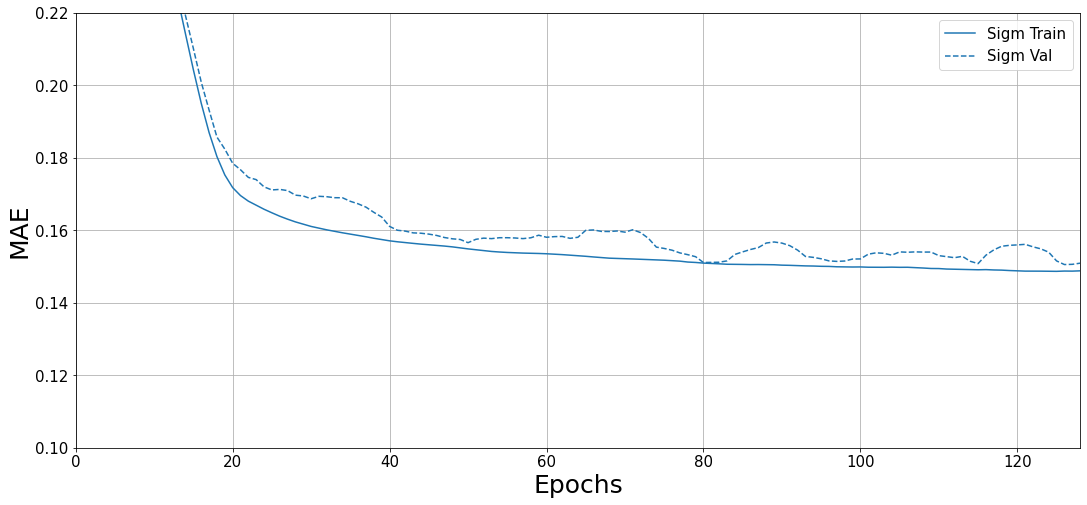

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [48]:
activ = "ReLU"
model2 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3256,  mae:0.4020,  mse:0.3256,  val_loss:0.1698,  val_mae:0.2609,  val_mse:0.1698,  
....................................................................................................
Epoch: 100, loss:0.0343,  mae:0.1175,  mse:0.0343,  val_loss:0.0416,  val_mae:0.1277,  val_mse:0.0416,  
...............

Text(0, 0.5, 'MAE')

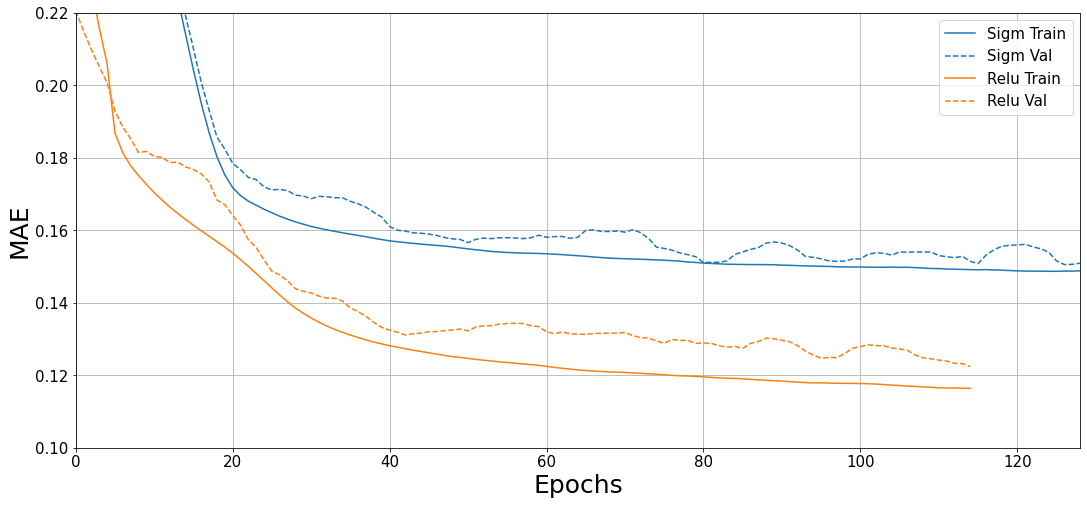

In [49]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [50]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2655,  mae:0.3636,  mse:0.2655,  val_loss:0.1641,  val_mae:0.2701,  val_mse:0.1641,  
....................................................................................................
Epoch: 100, loss:0.0348,  mae:0.1162,  mse:0.0348,  val_loss:0.0411,  val_mae:0.1219,  val_mse:0.0411,  
.....................................................

Text(0, 0.5, 'MAE')

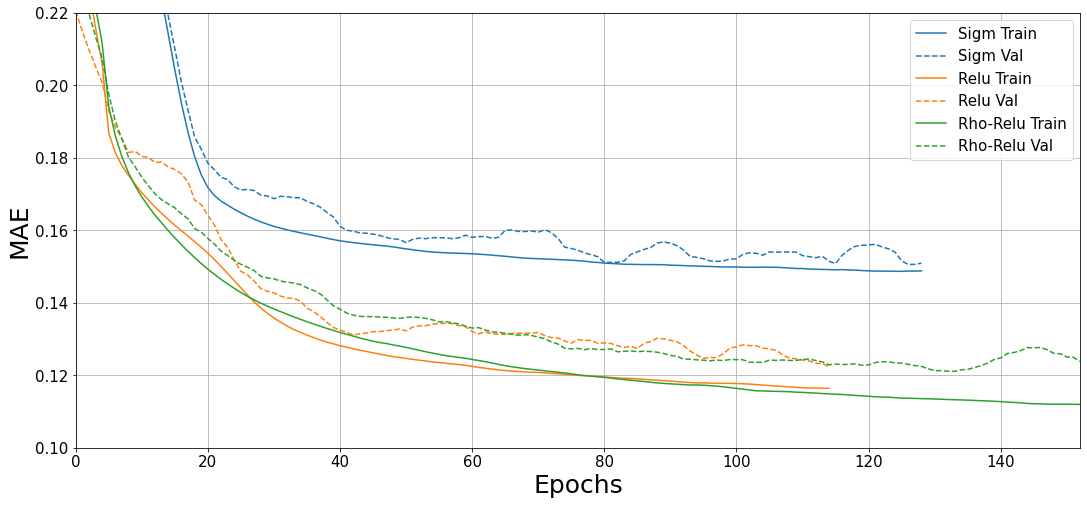

In [51]:
histories['rho-ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [52]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2792,  mae:0.3699,  mse:0.2792,  val_loss:0.1722,  val_mae:0.2779,  val_mse:0.1722,  
....................................................................................................
Epoch: 100, loss:0.0340,  mae:0.1166,  mse:0.0340,  val_loss:0.0397,  val_mae:0.1268,  val_mse:0.0397,  
..........................................................

Text(0, 0.5, 'MAE')

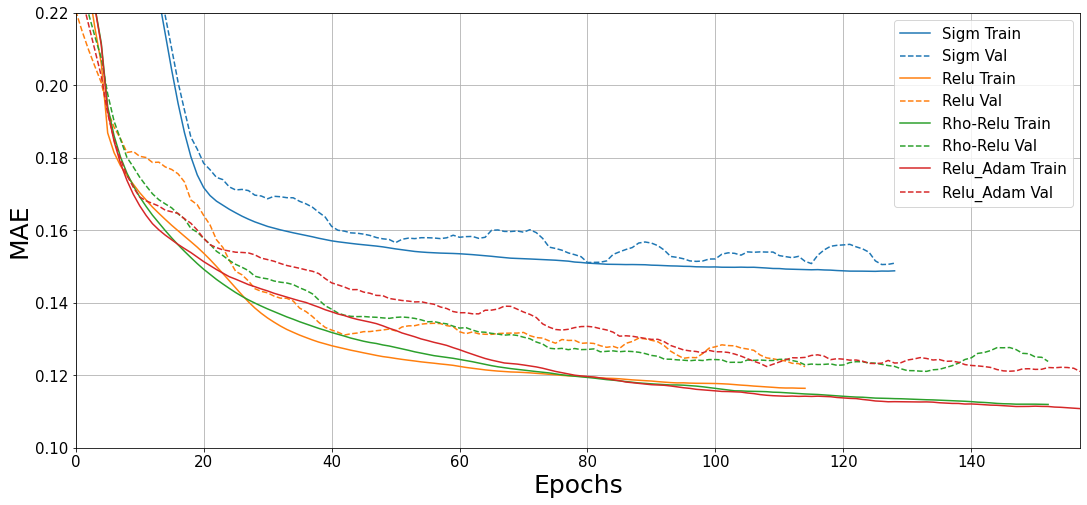

In [53]:
histories['ReLU_Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [54]:
model5 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2724,  mae:0.3768,  mse:0.2724,  val_loss:0.1640,  val_mae:0.2715,  val_mse:0.1640,  
....................................................................................................
Epoch: 100, loss:0.0357,  mae:0.1194,  mse:0.0357,  val_loss:0.0435,  val_mae:0.1305,  val_mse:0.0435,  
.....................................................

Text(0, 0.5, 'MAE')

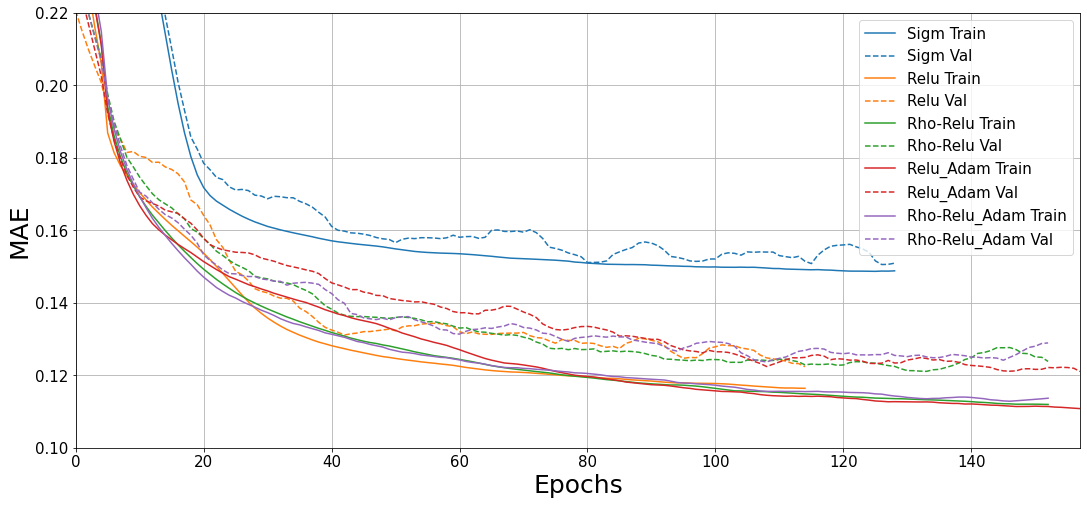

In [55]:
histories['rho-ReLU_Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.10, 0.22])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

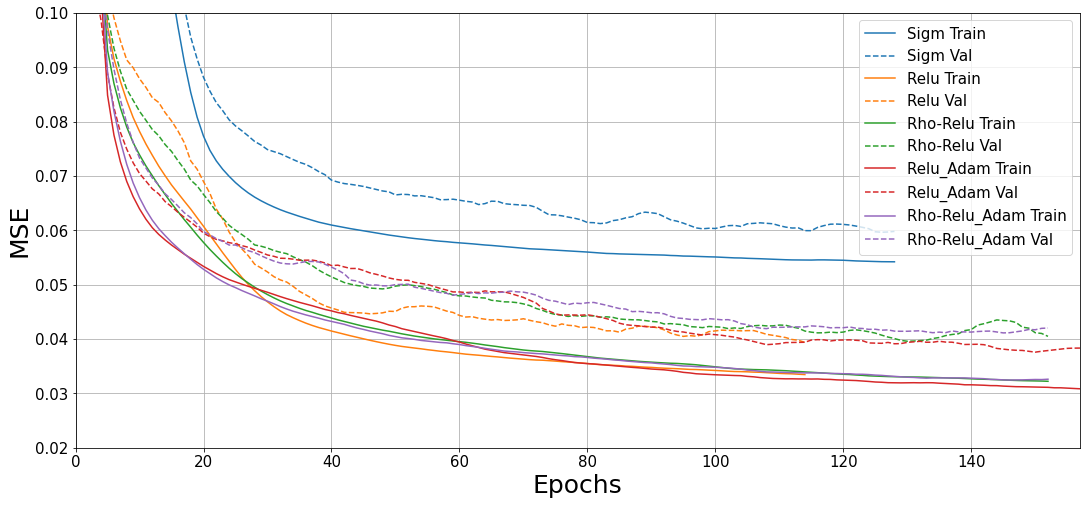

In [57]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.02, 0.1])
plt.ylabel('MSE')

In [58]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

2068/2068 - 0s - loss: 0.0482 - mae: 0.1369 - mse: 0.0482
Testing set for model 1, Mean Abs Error:    0.13692


In [59]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

2068/2068 - 0s - loss: 0.0320 - mae: 0.1130 - mse: 0.0320
Testing set for model 2, Mean Abs Error:              0.11299


In [60]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

2068/2068 - 0s - loss: 0.0305 - mae: 0.1101 - mse: 0.0305
Testing set for model 3, Mean Abs Error:              0.11009


In [61]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

2068/2068 - 0s - loss: 0.0323 - mae: 0.1147 - mse: 0.0323
Testing set for model 4, Mean Abs Error:              0.11471


In [62]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

2068/2068 - 0s - loss: 0.0330 - mae: 0.1088 - mse: 0.0330
Testing set for model 5, Mean Abs Error:              0.10882


In [63]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.13692145, 0.11298645, 0.110091604, 0.11470821, 0.10882103]

In [64]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.048171, 0.03200863, 0.030514518, 0.032287985, 0.032968722]

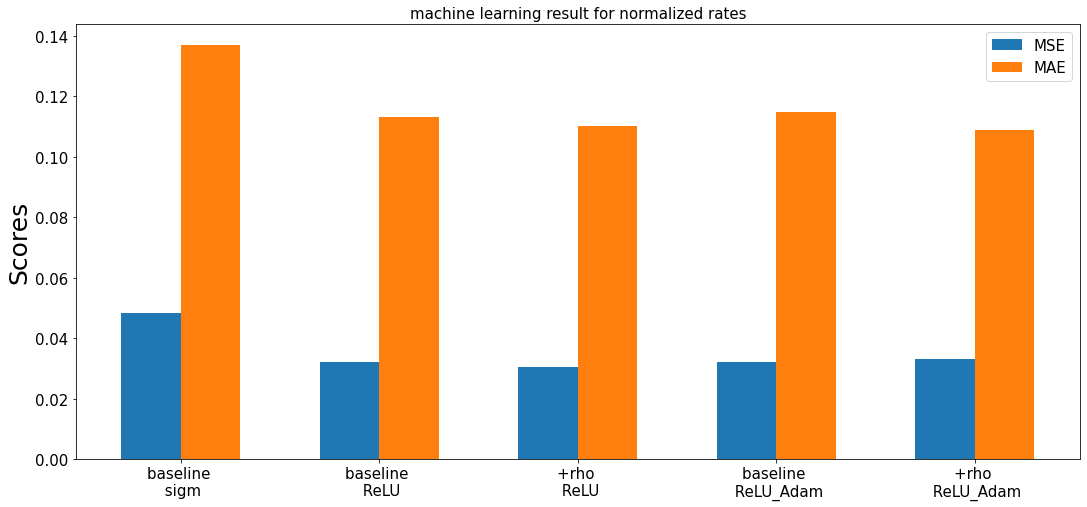

In [65]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['baseline \n sigm',
 'baseline \n ReLU',
 '+rho \n ReLU',
 'baseline \n ReLU_Adam',
 '+rho \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [66]:
test_true  = np.exp(test_labels.pop('mult_num'))

In [67]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [68]:
labels = [ "mult_num" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=labels)

In [69]:
p1.describe()

mult_num
count  2068.000000
mean      0.032283
std       0.950669
min      -3.112648
25%      -0.664873
50%       0.043747
75%       0.739315
max       2.617853

In [70]:
train_labels_stats

count      mean       std        min       25%       50%       75%  \
mult_num  9819.0 -4.863671  3.801702 -16.801191 -7.497925 -4.739416 -2.072818   

               max  
mult_num  5.784613

In [71]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [72]:
test_predict1.describe()

mult_num
count  2.068000e+03
mean   7.031829e-01
std    4.668044e+00
min    5.604950e-08
25%    6.165813e-04
50%    9.119337e-03
75%    1.283496e-01
max    1.621667e+02

In [73]:
np.exp(test_dataset1.head())

q_s          n_s           r_s           v_s       cwc       r_c  \
3   0.000009  2347.799561  4.888702e-07  3.174302e-09  0.000118  0.000005   
7   0.000010  2300.999512  9.549402e-07  6.023295e-09  0.000077  0.000005   
8   0.000010  2285.800049  1.056900e-06  6.618804e-09  0.000069  0.000005   
12  0.000011  2231.799805  1.374900e-06  8.352299e-09  0.000041  0.000005   
17  0.000012  2167.900146  1.608800e-06  9.372204e-09  0.000017  0.000005   

    temp  
3    inf  
7    inf  
8    inf  
12   inf  
17   inf

In [74]:
test_predict1.head()

mult_num
0  0.423064
1  0.362301
2  0.345069
3  0.230890
4  0.062172

In [75]:
test_dataset2.head()

q_s       n_s        r_s        v_s        cwc        r_c  \
3  -11.620110  7.761234 -14.531169 -19.568178  -9.044826 -12.155304   
7  -11.518903  7.741099 -13.861617 -18.927631  -9.465233 -12.155304   
8  -11.497150  7.734471 -13.760170 -18.833351  -9.581404 -12.155304   
12 -11.423085  7.710564 -13.497129 -18.600729 -10.104381 -12.155304   
17 -11.353872  7.681514 -13.340022 -18.485518 -10.964804 -12.155304   

          temp  
3   266.079987  
7   266.339996  
8   266.410004  
12  266.690002  
17  267.049988

In [76]:
test_predict1  = test_predict1['mult_num']

In [77]:

p2 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2 = test_predict2['mult_num']

In [78]:

p3 = pd.DataFrame(data=model4.predict(normed_test_data1), columns=labels)

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3 = test_predict3['mult_num']


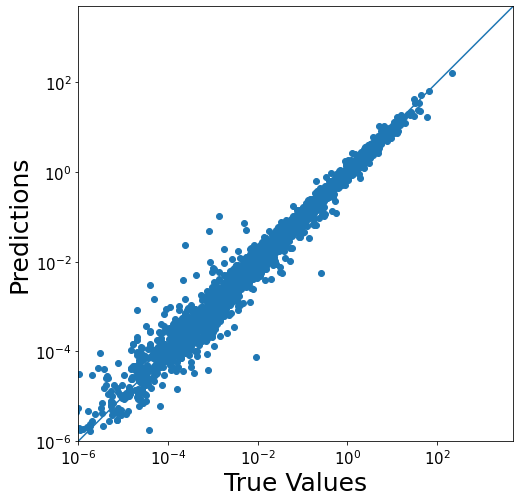

In [79]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-6, 5e3

a = plt.axes(aspect='equal')
plt.scatter(test_true, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

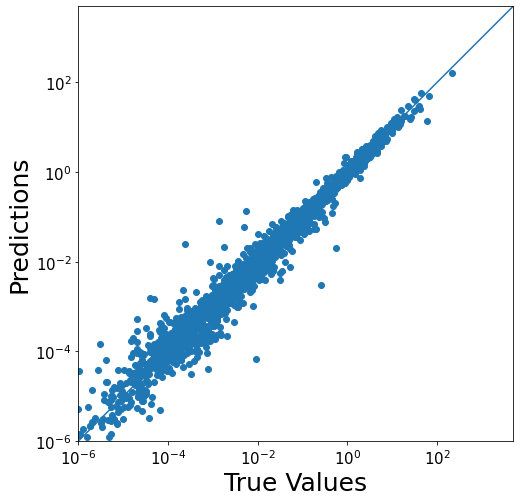

In [80]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

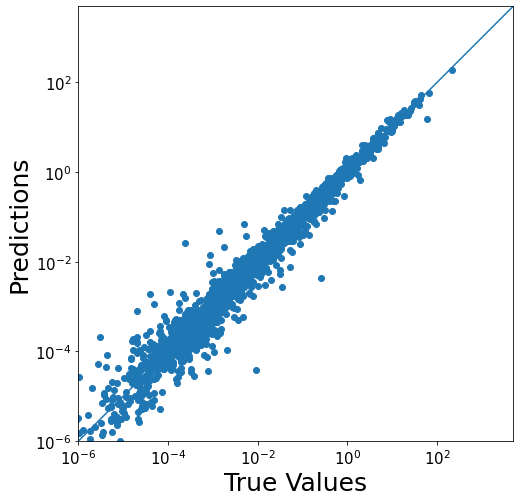

In [81]:
a = plt.axes(aspect='equal')
plt.scatter(test_true, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [82]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [83]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [84]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T'
labels   = 'mult_rimedice_cloud_num'
filename = 'saved_model_v2/mult_rimedice_cloud_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, True, True, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedice_cloud_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedice_cloud_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,filename)

features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T, rho'
filename = 'saved_model_v2/mult_rimedice_cloud_model3_'+version+'.nc'
logtransform = np.array([True, True, True, True, True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedice_cloud_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,filename)



Saving model to saved_model_v2/mult_rimedice_cloud_model1_07.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T
  Labels:     mult_rimedice_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/mult_rimedice_cloud_model2_07.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, cwc, rc, T
  Labels:     mult_rimedice_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activati